<a href="https://colab.research.google.com/github/Yunsubin-SMU/2022-1_DL/blob/main/py27_MLP_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 라이브러리 임포트**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

# **1. MNIST train, test dataset 가져오기**



In [2]:
# "": 현재 폴더에 MNIST 있음

mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), # train용으로 쓰겠다.  
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), # test용으로 쓰겠다.  
                      target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# **2. 대략적인 데이터 형태**


mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


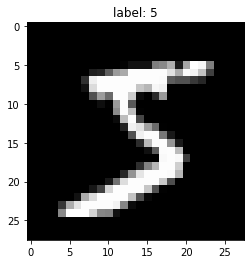

In [5]:
print ("mnist_train 길이: ", len(mnist_train))
print ("mnist_test 길이: ", len(mnist_test))

# 데이터 하나 형태 
image, label= mnist_train.__getitem__(0) # 0번째 데이터
print ("image data 형태: ", image.size())
print ("label: ", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# **3. 데이터 로드 함수**

**학습시킬 때 batch_size 단위로 끊어서 로드하기 위함**

In [6]:
# hyper parameters
batch_size = 1024
learning_rate = 0.01 # 0.1, 0.01, 0.001, 0.0001 ....
num_epoch = 400

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, # mnist_train을 학습시키자
                                           shuffle=True, num_workers=2, drop_last = True) 
                                            # batch_size만큼 나눌 때 나머지는 버리기 

test_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, # mnist_train을 학습시키자
                                           shuffle=False, num_workers=2, drop_last = True)

**데이터 로드함수 이해하기**

[0]
한 번에 로드되는 데이터 크기: 1024


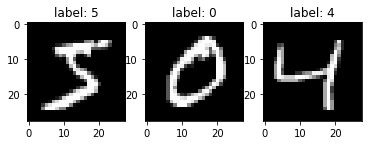

[1]
한 번에 로드되는 데이터 크기: 1024


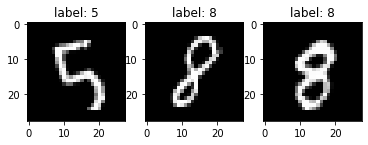

[2]
한 번에 로드되는 데이터 크기: 1024


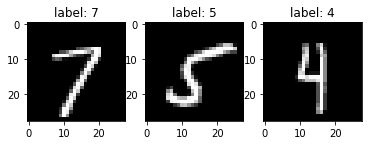

[3]
한 번에 로드되는 데이터 크기: 1024


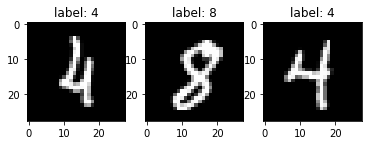

[4]
한 번에 로드되는 데이터 크기: 1024


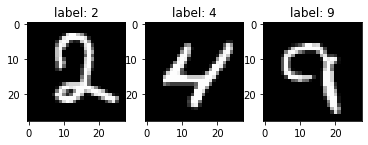

[5]
한 번에 로드되는 데이터 크기: 1024


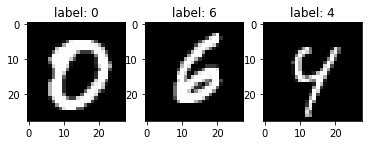

In [9]:
n = 3 # 샘플로 그려볼 데이터 수
for i, [imgs, labels] in enumerate(test_loader): # batch_size만큼
    if i>5:
        break
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy() # image 타입을 numpy로 변환 (1, 28, 28)
        img = img.reshape((img.shape[1], img.shape[2])) # (1, 28, 28) → (28, 28)
        # print img.shape
        
        plt.subplot(1, n, j+1) # (1, 3) 형태 플랏의 j번 째 자리에 그리겠다.
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# **4. 모델 선언**

In [11]:
# 모델 선언
# * 퍼셉트론(2 hidden layer) *
model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.Sigmoid(), #nn.ReLU(),   #nn.Sigmoid()  91.89%
    nn.Linear(256, 128),
    nn.Linear(128, 10),
)
# 파라미터 보기
# print(list(model.parameters())) # 초기 파라미터 출력
model = model.cuda()

In [12]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size만큼
        img = imgs # x
        #label = Variable(labels) # y
        label = Variable(labels).cuda()
        # .cuda(): GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남. 
        
        # print(img.shape) 결과 → (batch_size, 1, 28, 28) → (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        # (batch_size, 28, 28) → (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        #img = Variable(img, requires_grad=False)
        img = Variable(img, requires_grad=False).cuda()
        
        output = imodel(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [13]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 11.27592945098877


# **5. loss, optimizer**

In [14]:
loss_func = nn.CrossEntropyLoss() # logit(# of classes), target(1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# **6. 학습**

In [15]:
num_epoch = 400
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader): # batch_size 만큼
        img = imgs # (batch_size, 1, 28, 28)
        #label = Variable(labels) # (batch_size)
        label = Variable(labels).cuda() #(batch_size)
        
        # (batch_size, 1, 28, 28) → (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        # (batch_size, 28, 28) → (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        #img = Variable(img, requires_grad=False)
        img = Variable(img, requires_grad=False).cuda()
        
        optimizer.zero_grad()
        output = model(img) # forward prop.
        loss = loss_func(output, label) # logit(# of classes), target(1)
        
        loss.backward() # back prop.
        optimizer.step() # weight 조정
        
    if i%50==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)
        print (loss)

0..
Accuracy of Test Data: 11.245622634887695
tensor(2.2965, device='cuda:0', grad_fn=<NllLossBackward0>)
50..
Accuracy of Test Data: 80.70783996582031
tensor(0.6793, device='cuda:0', grad_fn=<NllLossBackward0>)
100..
Accuracy of Test Data: 87.90241241455078
tensor(0.4074, device='cuda:0', grad_fn=<NllLossBackward0>)
150..
Accuracy of Test Data: 89.67874145507812
tensor(0.3645, device='cuda:0', grad_fn=<NllLossBackward0>)
200..
Accuracy of Test Data: 90.40948486328125
tensor(0.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
250..
Accuracy of Test Data: 90.9112319946289
tensor(0.3407, device='cuda:0', grad_fn=<NllLossBackward0>)
300..
Accuracy of Test Data: 91.32038116455078
tensor(0.3411, device='cuda:0', grad_fn=<NllLossBackward0>)
350..
Accuracy of Test Data: 91.5998764038086
tensor(0.2910, device='cuda:0', grad_fn=<NllLossBackward0>)


# **7. 테스트**

In [16]:
ComputeAccr(test_loader, model) # 96.  %(ReLU), 92.48%(ReLU X)

Accuracy of Test Data: 91.82212829589844


# **8. 학습된 파라미터 저장**

In [18]:
netname = './mlp_weight.pkl'
torch.save(model, netname, )

# model = torch.load(netname)

# **9. (Optional) 실습1에 쓰인 .npz 만드는 법**

In [20]:
'''
np.savez_compressed('./mpl_weight.npz',
                    W1=W1, b1=b1, 
                    W2=W2, b2=b2,
                    W3=W3, b3=b3)
'''

"\nnp.savez_compressed('./mpl_weight.npz',\n                    W1=W1, b1=b1, \n                    W2=W2, b2=b2,\n                    W3=W3, b3=b3)\n"